In [1]:
from matplotlib import pyplot as plt
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor

import shap



/Users/krzysztofspalinski/Projects/wec2024/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
df = pd.read_csv('processed_df_modelling_fixed_2.csv').merge(
    pd.read_csv('processed_df_modelling_raw.csv')[['partitions', 'Longitude', 'Latitude', 'no_loc_in10km']],
    left_on=['Longitude', 'Latitude'],
    right_on=['Longitude', 'Latitude']
)

In [24]:
y = df['y'].copy()

In [25]:
def municipality_transform(x):
    if x == 1:
        return 'Urban'
    if x == 2:
        return 'Rural'
    if x == 3:
        return 'Mixed'
    raise RuntimeError

def partitions_transform(x):
    if x == 1:
        return 'Russia'
    if x == 2:
        return 'Prussia'
    if x == 3:
        return 'Austria'
    raise RuntimeError

In [37]:
x = df[
    [
        'partitions',
        'type_of_municipality',
        'SLD_percent',
        'PO_percent',
        'frekwencja_wyborcza',
        'PSL_percent',
        'Konfederacja_percent',
        'revenues_per_capita_PIT',
        'percent_over_60',
        'min_dist',
        'no_loc_in10km',
        'education_share_higher',
        'cars_per_1000_persons',
        'healthcare_advices_ratio_total'
    ]
].copy()

x['type_of_municipality'] = x['type_of_municipality'].apply(municipality_transform)
x['partitions'] = x['partitions'].apply(partitions_transform)
x.rename(columns={'frekwencja_wyborcza': 'voters_turnout'}, inplace=True)

In [38]:
# Define the preprocessor for categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        (
            'cat', 
            OneHotEncoder(), 
             [
                 'partitions', 
                 'type_of_municipality'
             ]
        )
    ],
    remainder='passthrough'
)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor())
])

In [39]:
pipeline.fit(x, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['partitions',
                                                   'type_of_municipality'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=Fa...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [40]:
trained_model = pipeline.steps[1][1]
transformed_df = pd.DataFrame(pipeline.steps[0][1].transform(x),
                             columns=[
                                 x.replace('remainder__', '') for x in pipeline.steps[0][1].get_feature_names_out()
                             ])

In [41]:
explainer = shap.Explainer(
    trained_model, 
    transformed_df
)
shap_values = explainer(transformed_df)

 96%|=================== | 2378/2477 [00:11<00:00]       

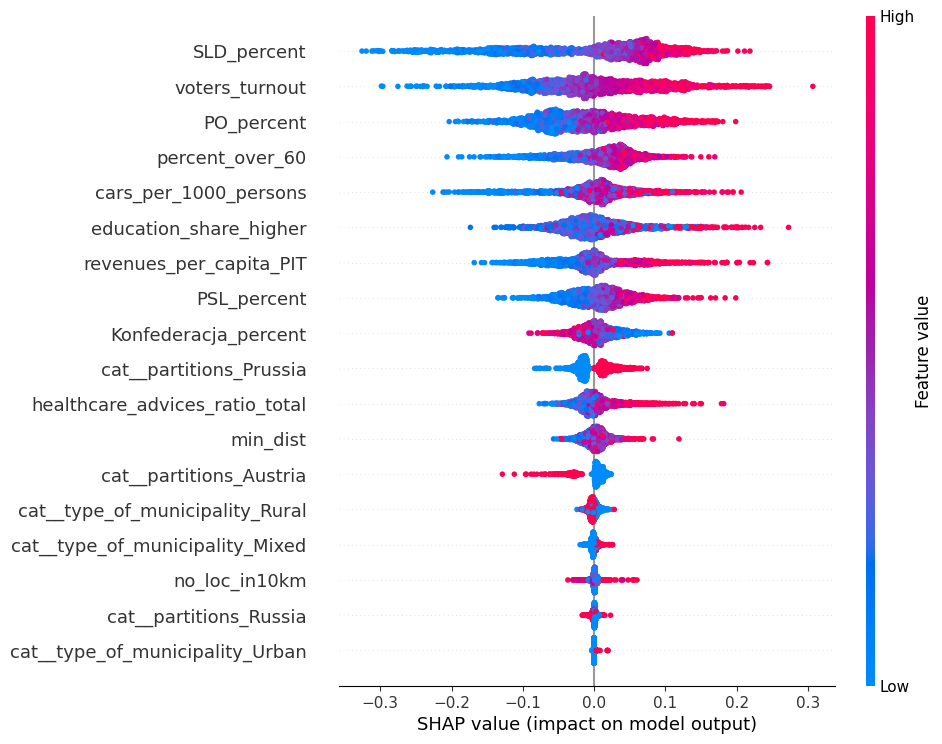

In [81]:
shap.plots.beeswarm(shap_values, max_display=50, show=False)
plt.savefig('beeswarm.png', dpi=300, bbox_inches='tight')

In [33]:
def plot_for_var(col_name, alpha=0.1):
    idx_num = list(transformed_df.columns).index(col_name)
    
    plt_x = transformed_df[col_name]
    plt_y = shap_values.values[:, idx_num]
    
    plt.scatter(plt_x, plt_y, alpha=alpha)
    
    plt.xlabel(f'Value of {col_name}')
    plt.ylabel('SHAP value of given observation')

In [86]:
def plot_for_vars(col_names, alpha=0.1):
    num_cols = len(col_names)
    num_rows = (num_cols + 1) // 2  # Calculate the number of rows needed
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5*num_rows))
    
    for i, col_name in enumerate(col_names):
        row = i // 2
        col = i % 2
        idx_num = list(transformed_df.columns).index(col_name)
        plt_x = transformed_df[col_name]
        plt_y = shap_values.values[:, idx_num]
        
        axes[row, col].scatter(plt_x, plt_y, alpha=alpha)
        axes[row, col].set_xlabel(f'Value of {col_name}', fontsize=14)
        axes[row, col].set_ylabel('SHAP value of given observation', fontsize=14)
        axes[row, col].set_title(f'SHAP value vs {col_name}', fontsize=16)
    
    plt.tight_layout()

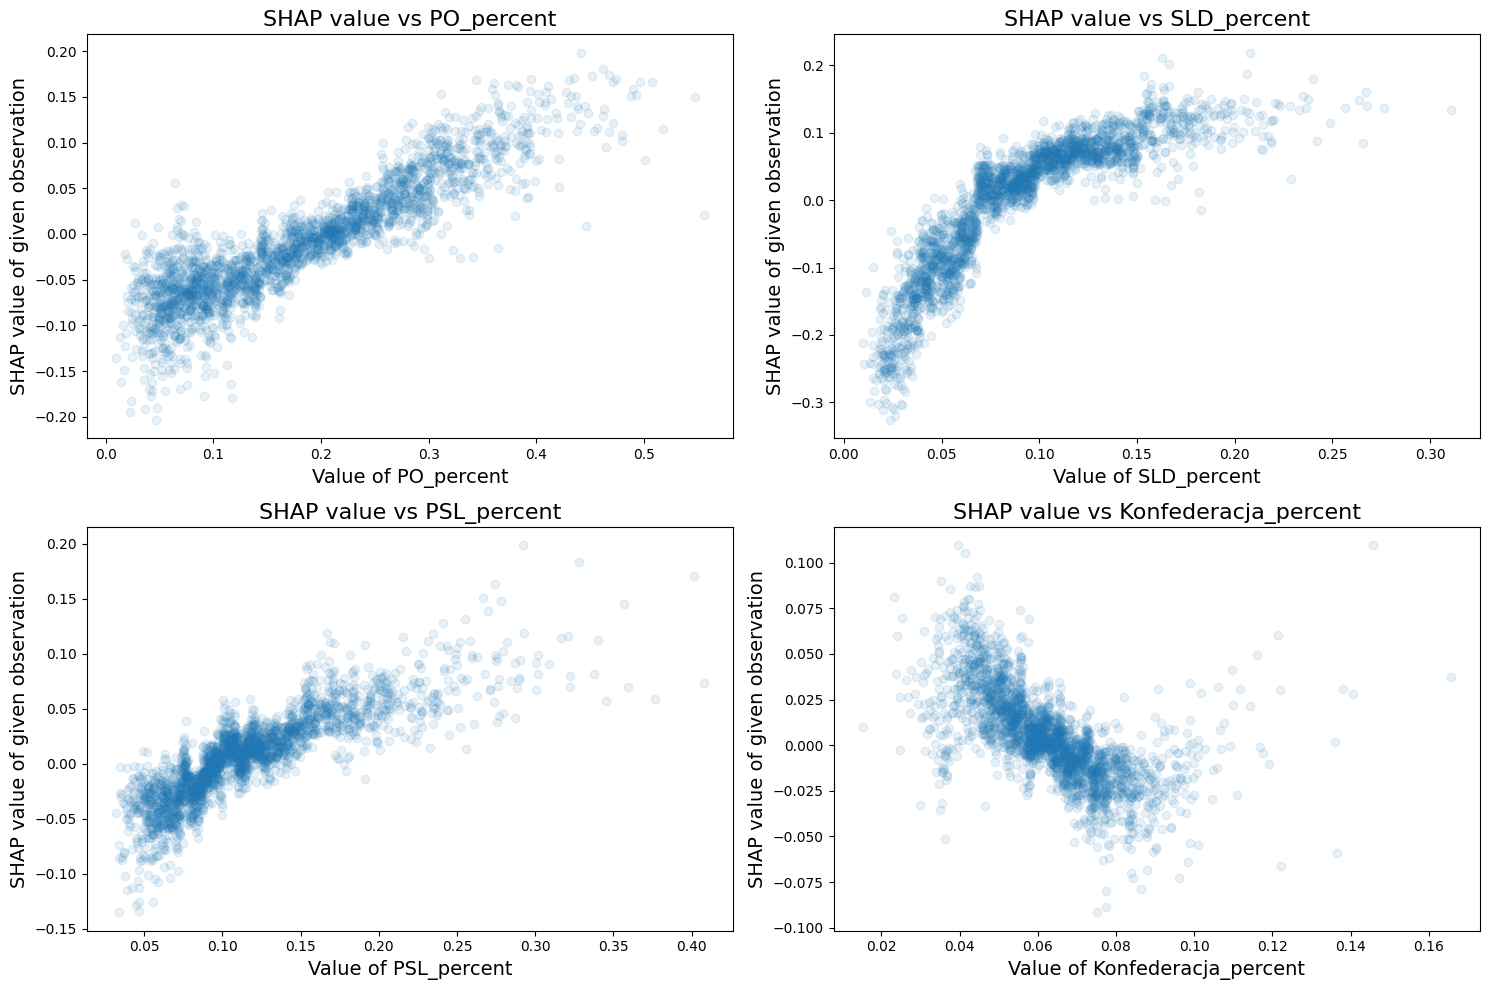

In [87]:
plot_for_vars(['PO_percent', 'SLD_percent', 'PSL_percent', 'Konfederacja_percent'])
plt.savefig('parties_partial.png', dpi=300, bbox_inches='tight')